# Mount the Google Drive storage

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#  Install the required libraries

In [2]:
# !pip install git+https://github.com/fastai/fastai 
# !pip install git+https://github.com/fastai/fastcore

## Setup the fastbook

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

# Move to the working directory

In [4]:
!pwd

/content


In [5]:
%cd "/content/gdrive/MyDrive"

/content/gdrive/MyDrive


In [6]:
!pwd

/content/gdrive/MyDrive


## Sync the files with fastai repo

In [7]:
!git pull

Already up to date.


In [8]:
# Importing libs
from fastbook import *

# Import the Computer Vision related libs
from fastai.vision.widgets import *

- The Image dataset consists of bees and wasps.
- The download link is [bees-vs-wasps](https://www.kaggle.com/jerzydziewierz/bee-vs-wasp)
- Download the images and put them in your drive folder:
```
/content/gdrive/MyDrive/images/
```

In [9]:
# Setting the categories and the file-paths
fly_types = "bee", "wasp"
path = Path("images/bee_vs_wasp")

In [10]:
# saving file-paths in variable fns:
fns = get_image_files(path)
fns

(#4596) [Path('images/bee_vs_wasp/bee/36310704561_680ebebf6b_n.jpg'),Path('images/bee_vs_wasp/bee/38514571975_68fd0ce74e_m.jpg'),Path('images/bee_vs_wasp/bee/4817182248_f0d7899826_m.jpg'),Path('images/bee_vs_wasp/bee/4880255764_d6b54aa4c4_m.jpg'),Path('images/bee_vs_wasp/bee/36979072280_0687a62b01_w.jpg'),Path('images/bee_vs_wasp/bee/4879642917_e3cdd31840_n.jpg'),Path('images/bee_vs_wasp/bee/4777728098_5a6c70a44f_m.jpg'),Path('images/bee_vs_wasp/bee/4681248749_805a0459e3_n.jpg'),Path('images/bee_vs_wasp/bee/36009801074_7c60184f0c_n.jpg'),Path('images/bee_vs_wasp/bee/4551971928_0c403c845d_n.jpg')...]

- check for corrupted files

In [11]:
corrupt_files = verify_images(fns)
corrupt_files

(#3) [Path('images/bee_vs_wasp/bee/7174355503_ff111ef10e_n.jpg'),Path('images/bee_vs_wasp/bee/8716414757_4bf4acb9ef_w.jpg'),Path('images/bee_vs_wasp/bee/7450512990_5fb5c6ee2f_n.jpg')]

- remove corrupt files by unlinking them from the Path variable.

In [12]:
corrupt_files.map(Path.unlink)

(#3) [None,None,None]

## Create datablock object

In [13]:
bee_wasp = DataBlock(
    # what are the data we are providing? we are giving
    # images and their category labels
    blocks = (ImageBlock, CategoryBlock),
    # how to retrieve the data: using get_image_files
    get_items = get_image_files,
    # how to split data for validation set: percentage of total obs:
    splitter = RandomSplitter(valid_pct=0.3, seed = 42),
    # How to identify the labels?
    get_y = parent_label,
    # transform_data = Resize all images to get uniform size and less useless 
    # data:
    item_tfms = Resize(128)
)

- Create the dataloader

In [14]:
dls = bee_wasp.dataloaders(path)

- check few images of validation batch

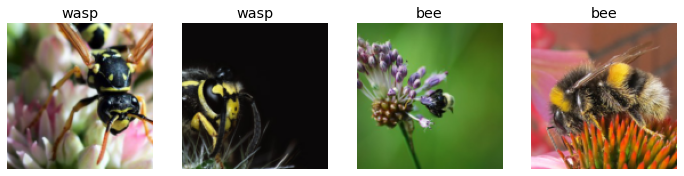

In [15]:
dls.valid.show_batch(max_n=4, nrows = 1)

## When we resize all images to same size , we loose some details , 
## to tackle this , we can use randomly cropped versions of same
## image to the model
- Remember our validation data is still intact , it hasn't been transformed.

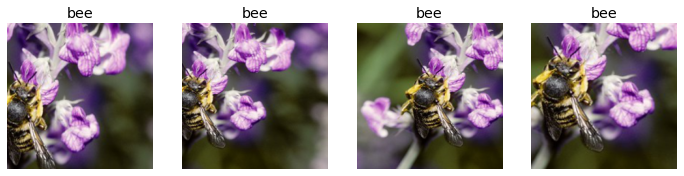

In [16]:
bee_wasp = bee_wasp.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.3)
)
dls = bee_wasp.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## As all our images are of same size , we can apply batch transforms
## to save time using GPU.

In [17]:
bee_wasp = bee_wasp.new(
    item_tfms=RandomResizedCrop(size=224, min_scale=0.2), 
    # try changing min_scale
    batch_tfms=aug_transforms()
)
dls = bee_wasp.dataloaders(path)

In [18]:
# dls.valid.show_batch(max_n=12, nrows=3, unique=True)

# Training a CNN learner and fine-tuning it

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.469876,0.210404,0.069717,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.277455,0.197375,0.063181,00:24
1,0.215865,0.157476,0.049383,00:24
2,0.193584,0.162211,0.049383,00:24
3,0.165540,0.143888,0.044299,00:24


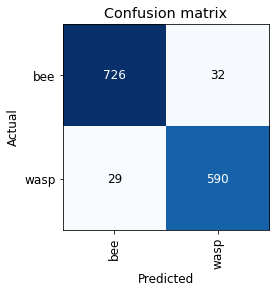

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [37]:
from google.colab import files
uploaded = files.upload()

Saving B00003.jpg to B00003.jpg


- The uploaded image is :

In [38]:
img_name = [key for key in uploaded.keys()][0]
img_name

'B00003.jpg'

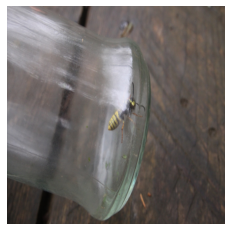

In [39]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open(BytesIO(uploaded[img_name]))
plt.imshow(im)
plt.axis('off')
plt.show()

- Lets make the prediction

In [40]:
prediction = learn.predict(uploaded[img_name])
prediction
print(f"The given image is of :{prediction[0]}")
print(f"The probability for it being a wasp is :{prediction[2][1]*100:0.03f}%")
print(f"The probability for it being a bee is :{prediction[2][0]*100:0.03f}%")

The given image is of :wasp
The probability for it being a wasp is :99.999%
The probability for it being a bee is :0.001%


## Analyze the errors

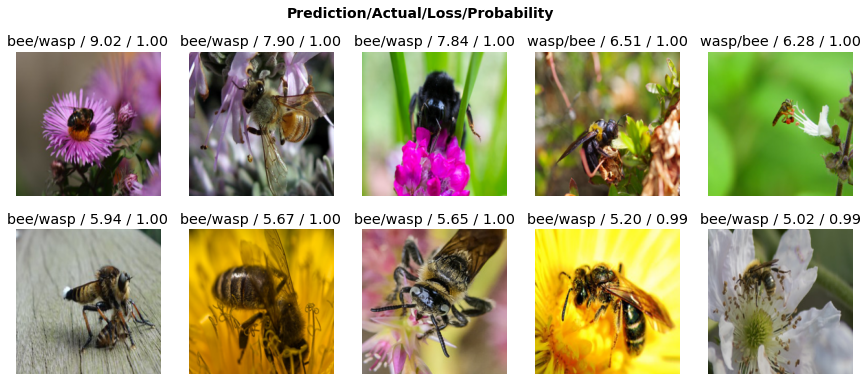

In [32]:
# get images with highest errors
interp.plot_top_losses(10, nrows=2)

- In the above images we can easily that the first images looks like a bee but
<br>wrongly labelled as wasp, we can see such mis-labelling in more images

# Improve the Model:
- Remove the mislabelled images 
- or change labels.